

> Import needed libraries and import cleaned data



In [25]:
import sys
import pandas as pd
from string import punctuation
import operator
import nltk
import numpy as np
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from google.colab import files
from google.colab import drive
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from imblearn.under_sampling import NearMiss
from keras.models import Model
from keras.layers import Concatenate, Dense, Input, Dropout
from keras.callbacks import EarlyStopping
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model
from tensorflow import keras
import tensorflow as tf

#read data from Google Drive
#drive.mount('/content/drive')

#Get ML data from Google Drive and get only the selected columns
df = pd.read_excel('/content/drive/My Drive/ML/modified_ml_data.xlsx')
df = df[["handler_id", "priority", "severity", "reproducibility", "summary", "category_id", "description", "steps_to_reproduce", "additional_information", "time_estimation", "tag_id", "total_hours"]]




# Suitable encodings for numeric features
*   handler_id        - one hot encoding (20 distinct handler_ids)
*   priority          - integer encoding
*   severity          - integer encoding
*   reproducability   - integer encoding
*   category_id       - one hot encoding (52 distinct category_ids)
*   time_estimation   - integer encoding (boolean)
*   tag_id            - integer encoding (boolean)



In [26]:
#one_hot encoding in place for handler_id and category_id
one_hot = pd.get_dummies(df, columns=['handler_id', 'category_id'], prefix='', prefix_sep='')
df = one_hot




# NLP process







> Calculate number of samples / number of words per sample








In [ ]:
def no_samples_per_no_words_per_sample(column_name):
  number_of_samples = len(df.index)
  print('number of samples: ', number_of_samples)
  df['totalwords'] = df[column_name].str.split().str.len()
  max = df['totalwords'].max()
  print('max amount of words: ', max)
  min = df['totalwords'].min()
  print('min amount of words: ', min)
  average_words_per_sample = df['totalwords'].mean()
  print('average words per sample: ', average_words_per_sample)
  samples_per_words_per_sample = number_of_samples / average_words_per_sample
  print('number of samples / number of words per sample: ', samples_per_words_per_sample)

no_samples_per_no_words_per_sample('description')
no_samples_per_no_words_per_sample('summary')
no_samples_per_no_words_per_sample('steps_to_reproduce')
no_samples_per_no_words_per_sample('additional_information')

number of samples:  1915
max amount of words:  157
min amount of words:  1
average words per sample:  21.15509138381201
number of samples / number of words per sample:  90.52194411532386
number of samples:  1915
max amount of words:  15
min amount of words:  1
average words per sample:  7.024543080939948
number of samples / number of words per sample:  272.6155961938745
number of samples:  1915
max amount of words:  200
min amount of words:  1
average words per sample:  23.01201044386423
number of samples / number of words per sample:  83.21741399655077
number of samples:  1915
max amount of words:  226
min amount of words:  1
average words per sample:  6.2464751958224545
number of samples / number of words per sample:  306.57289750877777


#Train and validation splits, vectorization and select K best features



> Train and validation split




In [27]:
df_train, df_test = train_test_split(df, stratify=df['total_hours'], test_size = 0.3, random_state = 42)

#prints (1340, 82) (575, 82)
print(df_train.shape, df_test.shape)

# Train and test subsets for text values -------------------------------------------------
train_texts_description, test_texts_description = df_train['description'], df_test['description']
train_texts_summary, test_texts_summary = df_train['summary'], df_test['summary']
train_texts_steps_to_reproduce, test_texts_reproduce = df_train['steps_to_reproduce'], df_test['steps_to_reproduce'] 
train_texts_additional_information, test_texts_additional_information = df_train['additional_information'], df_test['additional_information']
train_label, test_label = np.array(df_train['total_hours']), np.array(df_test['total_hours'])

# Train and test subsets for numeric values -------------------------------------------------
train_numerics_handler_id, test_numerics_handler_id = df_train.loc[:, '0':'73'], df_test.loc[:,'0':'73']
train_numerics_priority, test_numerics_priority = df_train['priority'], df_test['priority']
train_numerics_severity, test_numerics_severity = df_train['severity'], df_test['severity']
train_numerics_reproducibility, test_numerics_reproducibility = df_train['reproducibility'], df_test['reproducibility']
train_numerics_category_id, test_numerics_category_id = df_train.loc[:, '1':'604'], df_test.loc[:, '1':'604']
train_numerics_time_estimation, test_numerics_time_estimation = df_train['time_estimation'], df_test['time_estimation']
train_numerics_tag_id, test_numerics_tag_id = df_train['tag_id'], df_test['tag_id']

#print(test_numerics_category_id.shape)



(1340, 82) (575, 82)




> See how balanced train dataset is after train/test split




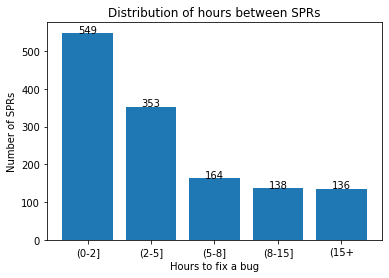

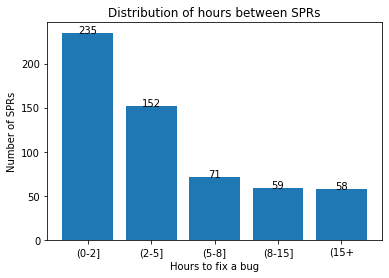

In [ ]:
def plot_distribution(label):
  categories = np.array(['(0-2]', '(2-5]', '(5-8]', '(8-15]', '(15+'])

  #Amount of SRPs fixed between (0,2]
  size_zero_to_two = label[label == 0].size

  #Amount of SRPs fixed between (2,5]
  size_two_to_five = label[label == 1].size

  #Amount of SRPs fixed between (5,8]
  size_five_to_eigth = label[label == 2].size

  #Amount of SRPs fixed between (8,15]
  size_eigth_to_fifteen = label[label == 3].size

  #Amount of SRPs fixed between (15+
  size_fifteen_plus = label[label == 4].size

  categorized_data = np.array([size_zero_to_two, size_two_to_five, size_five_to_eigth, size_eigth_to_fifteen, size_fifteen_plus])

  plt.bar(categories, categorized_data)
  xlocs=[i+1 for i in range(0,10)]
  for i, v in enumerate(categorized_data):
      plt.text(xlocs[i] - 1.0, v, str(v), ha='center')
  plt.xlabel('Hours to fix a bug')
  plt.ylabel('Number of SPRs')
  plt.title('Distribution of hours between SPRs')
  plt.show()

plot_distribution(train_label)
plot_distribution(test_label)





> Tokenization and TF-IDF vectorization



In [28]:
def ngram_vectorize(train_texts, test_texts):
    tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2))
    x_train = tfidf_vectorizer.fit_transform(train_texts)
    x_test = tfidf_vectorizer.transform(test_texts)

    #23838 uni+bigrams found from training data
    tfidf_dict = tfidf_vectorizer.vocabulary_
    print(len(tfidf_dict))
    print(tfidf_dict)
    return x_train, x_test

#vectorize training and test texts from description, summary, steps_to_reproduce and additional_information fields
x_train_description, x_test_description = ngram_vectorize(train_texts_description, test_texts_description)
x_train_summary, x_test_summary = ngram_vectorize(train_texts_summary, test_texts_summary)
x_train_steps_to_reproduce, x_test_steps_to_reproduce = ngram_vectorize(train_texts_steps_to_reproduce, test_texts_reproduce)
x_train_additional_information, x_test_additional_information = ngram_vectorize(train_texts_additional_information.astype('U').values, test_texts_additional_information.astype('U').values)

print('train_description shape: ', x_train_description.shape)
print('test description shape: ', x_test_description.shape)
print('train summary shape', x_train_summary.shape)
print('test summary shape', x_test_summary.shape)
print('train steps_to_reproduce shape', x_train_steps_to_reproduce.shape)
print('test steps_to_reproduce shape', x_test_steps_to_reproduce.shape)
print('train additional_information shape', x_train_additional_information.shape)
print('test additional_information shape', x_test_additional_information.shape)


23189
{'specified': 19413, 'object': 13328, 'found': 8666, 'check': 2519, 'either': 6839, 'id': 9568, 'name': 12700, 'correct': 4012, 'error': 7101, 'displayd': 6138, 'assemblys': 1073, 'child': 2610, 'part': 14440, 'moved': 12613, 'another': 656, 'location': 11416, 'assembly': 969, 'left': 10909, 'untouched': 21157, 'specified object': 19422, 'object found': 13331, 'found check': 8667, 'check either': 2527, 'either id': 6848, 'id name': 9579, 'name object': 12763, 'object correct': 13330, 'correct error': 4020, 'error displayd': 7115, 'displayd assemblys': 6139, 'assemblys child': 1074, 'child part': 2618, 'part moved': 14523, 'moved another': 12614, 'another location': 668, 'location assembly': 11418, 'assembly left': 1019, 'left untouched': 10920, 'catrrichedit': 2246, 'showstringmask': 18976, 'leaks': 10857, 'memory': 12047, 'catrrichedit showstringmask': 2247, 'showstringmask leaks': 18977, 'leaks memory': 10858, 'creating': 4350, 'new': 12994, 'file': 7873, 'conversion': 3758, 'r


> Select top k features for training and validation sets from text data columns
* description
    * original amount of features: 23 189
    * select top 20k features
* summary
    * original amount of features: 8 012
    * select top 5k features
* steps_to_reproduce
    * original amount of features: 19 074
    * select top 15k features
* additional_information
    * original amount of features: 7 274
    * select top 5k features





In [29]:
  
def select_top_k_features(x_train, train_label, x_test, k_features):
    #select top k features
    selector = SelectKBest(f_classif, k=min(k_features, x_train.shape[1]))
    selector.fit(x_train, train_label)
    x_train = selector.transform(x_train)
    x_test = selector.transform(x_test)

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    #print(x_train.shape)
    #print(x_test.shape)
    return x_train.toarray(), x_test.toarray()

#select k features for description, summary, steps_to_reproduce and additional_information fields
x_train_top_k_features_desc, x_test_top_k_features_desc = select_top_k_features(x_train_description, train_label, x_test_description, 20000)
x_train_top_k_features_summary, x_test_top_k_features_summary = select_top_k_features(x_train_summary, train_label, x_test_summary, 5000)
x_train_top_k_features_reprod, x_test_top_k_features_reprod = select_top_k_features(x_train_steps_to_reproduce, train_label, x_test_steps_to_reproduce, 15000)
x_train_top_k_features_addit, x_test_top_k_features_addit = select_top_k_features(x_train_additional_information, train_label, x_test_additional_information, 5000)

#put all training and validation text features into one column
stacked_training_text_data = np.concatenate([x_train_top_k_features_desc, x_train_top_k_features_summary, x_train_top_k_features_reprod, x_train_top_k_features_addit], axis=1)
stacked_testing_text_data = np.concatenate([x_test_top_k_features_desc, x_test_top_k_features_summary, x_test_top_k_features_reprod, x_test_top_k_features_addit], axis=1)
#print(stacked_training_text_data.shape)
print(stacked_testing_text_data.shape)



(575, 45000)


# First try without oversampling or undersampling 

> Undersample majority class




In [ ]:
# undersample = NearMiss(version=2)
# x, y = undersample.fit_resample(x_train, train_label)


# categories = np.array(['(0-2]', '(2-5]', '(5-8]', '(8-15]', '(15+'])

# #Amount of SRPs fixed between (0,2]
# size_zero_to_two = y[y == 0].size
# print(size_zero_to_two)

# #Amount of SRPs fixed between (2,5]
# size_two_to_five = y[y == 1].size

# #Amount of SRPs fixed between (5,8]
# size_five_to_eigth = y[y == 2].size

# #Amount of SRPs fixed between (8,15]
# size_eigth_to_fifteen = y[y == 3].size

# #Amount of SRPs fixed between (15+
# size_fifteen_plus = y[y == 4].size

# categorized_data = np.array([size_zero_to_two, size_two_to_five, size_five_to_eigth, size_eigth_to_fifteen, size_fifteen_plus])

# plt.bar(categories, categorized_data)
# xlocs=[i+1 for i in range(0,10)]
# for i, v in enumerate(categorized_data):
#     plt.text(xlocs[i] - 1.0, v, str(v), ha='center')
# plt.xlabel('Hours to fix a bug')
# plt.ylabel('Number of SPRs')
# plt.title('Distribution of hours between SPRs')
# plt.show()


# Creating MLP model, training metrics and predictions



> MLP model

*   NLP_inputs as one column
*   Each numeric/category column as a separate input (different encodings)


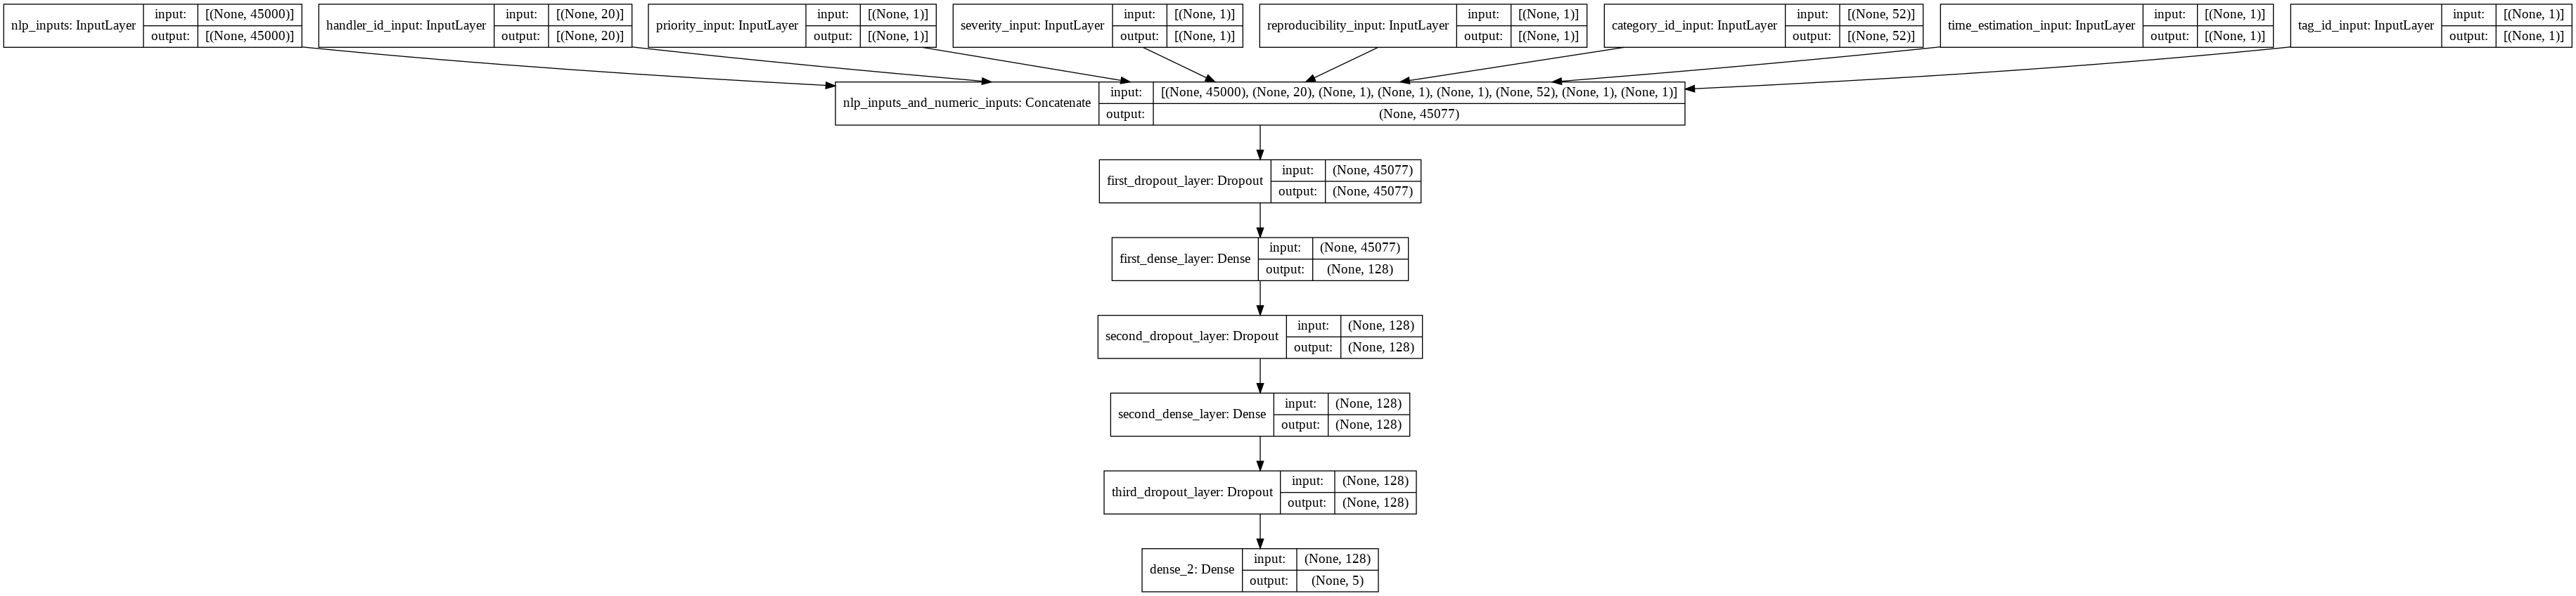

In [30]:
output_bias = np.log([
    549/(1340 - 549),
    353/(1340 - 353),
    164/(1340 - 164),
    138/(1340 - 138),
    136/(1340 - 136)             
])

weight_for_0 = (1 / 549) * (1340 / 5.0)
weight_for_1 = (1 / 353) * (1340 / 5.0)
weight_for_2 = (1 / 164) * (1340 / 5.0)
weight_for_3 = (1 / 138) * (1340 / 5.0)
weight_for_4 = (1 / 136) * (1340 / 5.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_3}

nlp_inputs = Input(shape=(stacked_training_text_data.shape[1:]), name="nlp_inputs")
#print(stacked_training_text_data.shape[1:])
#integer columns
handler_id_input = Input(shape=(train_numerics_handler_id.shape[1:]), name="handler_id_input")
#print(train_numerics_handler_id.shape[1:])
priority_input = Input(shape=(1), name="priority_input")
severity_input = Input(shape=(1), name="severity_input")
reproducibility_input = Input(shape=(1), name="reproducibility_input")
category_id_input = Input(shape=(train_numerics_category_id.shape[1:]), name="category_id_input")
#print(train_numerics_category_id.shape[1:])

#boolean columns
time_estimation_input = Input(shape=(1), name="time_estimation_input")
tag_id_input = Input(shape=(1), name="tag_id_input")

concatenated = concatenate([nlp_inputs, handler_id_input, priority_input, severity_input, reproducibility_input, category_id_input, time_estimation_input, tag_id_input], name='nlp_inputs_and_numeric_inputs')

x = Dropout(rate = 0.4, name="first_dropout_layer")(concatenated)
x = Dense(128, activation="relu", name="first_dense_layer")(x)
x = Dropout(rate = 0.4, name="second_dropout_layer")(x)
x = Dense(128, activation="relu", name="second_dense_layer")(x)
x = Dropout(rate = 0.4, name="third_dropout_layer")(x)

outputs = Dense(5, activation="softmax")(x)
model = Model(inputs=[nlp_inputs, handler_id_input, priority_input, severity_input, reproducibility_input, category_id_input, time_estimation_input, tag_id_input], outputs=outputs, name="bug_fixing_time_estimation_model")
#model.summary()
plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

#default learning rate 1e-3 = 0.001
#optimizer = keras.optimizers.Adam(learning_rate=1e-3)
#model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


> Training and training metrics for baseline model




Epoch 1/10
42/42 [==============================] - 1s 27ms/step - loss: 1.6380 - accuracy: 0.2231 - val_loss: 1.6192 - val_accuracy: 0.2277
Epoch 2/10
42/42 [==============================] - 1s 22ms/step - loss: 1.6315 - accuracy: 0.2082 - val_loss: 1.6181 - val_accuracy: 0.2492
Epoch 3/10
42/42 [==============================] - 1s 23ms/step - loss: 1.6304 - accuracy: 0.1963 - val_loss: 1.6089 - val_accuracy: 0.2615
Epoch 4/10
42/42 [==============================] - 1s 22ms/step - loss: 1.6206 - accuracy: 0.2134 - val_loss: 1.6069 - val_accuracy: 0.2492
Epoch 5/10
42/42 [==============================] - 1s 23ms/step - loss: 1.6162 - accuracy: 0.2172 - val_loss: 1.6096 - val_accuracy: 0.1785
Epoch 6/10
42/42 [==============================] - 1s 23ms/step - loss: 1.6138 - accuracy: 0.1963 - val_loss: 1.6182 - val_accuracy: 0.0985
Epoch 7/10
42/42 [==============================] - 1s 23ms/step - loss: 1.6037 - accuracy: 0.2030 - val_loss: 1.6153 - val_accuracy: 0.1077
Epoch 8/10
42

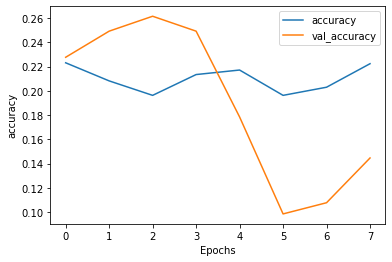

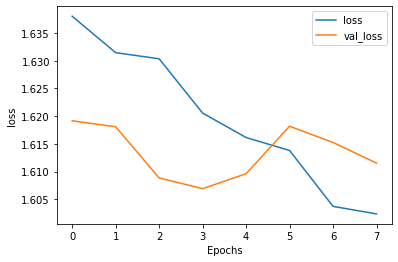

prediction probabilities:  [[0.19150898 0.20178597 0.21023172 0.1897645  0.20670885]
 [0.1974683  0.20244011 0.20172513 0.19506307 0.20330344]
 [0.18205532 0.19637868 0.2231346  0.18966722 0.20876424]
 ...
 [0.1990672  0.20678595 0.1982136  0.19424546 0.20168783]
 [0.16532066 0.20838535 0.22551996 0.19479217 0.20598182]
 [0.19202453 0.20092575 0.20230998 0.19969586 0.2050439 ]]
predicted class based on highest prediction probabilities:  [2 4 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 2 1 4 1 1 2 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 2 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 4 1 2 1 1 1 1 1 4 4 1 1
 1 2 1 1 4 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 4 1 1 1 1 1 1 1 1 1 2 1 1 2 2 4 1
 2 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 4 1 4 1 1 1 1 1 1 4 4 1 1 1 1 1 2
 1 4 1 1 4 1 1 4 1 1 1 1 1 1 2 1 0 1 1 2 1 1 1 2 1 2 1 1 1 1 1 2 1 2 1 1 1
 1 1 1 1 1 1 2 1 1 1 4 1 2 1 4 1 1 1 4 1 4 1 2 1 1 1 4 1 4 2 1 1 1 1 1 1 1
 2 1 1 1 1 1 1 1 1 1 4 2 1 2 1 1 1 1 1 1 1 2 1 1 1 1 2 4]
actual labels:  [1 0 1 2 1 1 4 0 2 4 1 4 0 1 0 3 0 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
no_predictions_spr = 250

train_label = pd.get_dummies(df_train['total_hours']).to_numpy()
test_label = pd.get_dummies(df_test['total_hours']).to_numpy()


callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 4, restore_best_weights=True)]

history = model.fit([stacked_training_text_data, train_numerics_handler_id, train_numerics_priority,
                     train_numerics_severity, train_numerics_reproducibility, train_numerics_category_id, 
                     train_numerics_time_estimation, train_numerics_tag_id], train_label, epochs=10, batch_size=32, 
                     validation_data = (([stacked_testing_text_data[no_predictions_spr:], test_numerics_handler_id[no_predictions_spr:], test_numerics_priority[no_predictions_spr:],
                     test_numerics_severity[no_predictions_spr:], test_numerics_reproducibility[no_predictions_spr:], test_numerics_category_id[no_predictions_spr:], 
                     test_numerics_time_estimation[no_predictions_spr:], test_numerics_tag_id[no_predictions_spr:]]), test_label[no_predictions_spr:]), callbacks=callbacks, class_weight=class_weight)


#--------------------------------------Training metrics ----------------------------------------------------------

print('Validation accuracy: {acc}, loss: {loss}'.format(acc=history.history['val_accuracy'][-1], loss=history.history['val_loss'][-1]))

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

predictions = model.predict((stacked_testing_text_data[:no_predictions_spr], test_numerics_handler_id[:no_predictions_spr], test_numerics_priority[:no_predictions_spr],
                     test_numerics_severity[:no_predictions_spr], test_numerics_reproducibility[:no_predictions_spr], test_numerics_category_id[:no_predictions_spr], 
                     test_numerics_time_estimation[:no_predictions_spr], test_numerics_tag_id[:no_predictions_spr]))
print("prediction probabilities: ", predictions)
predictions = np.argmax(predictions, axis = 1)
print("predicted class based on highest prediction probabilities: ", predictions)
test_label_2 = np.argmax(test_label[:no_predictions_spr], axis = 1)
print("actual labels: ", test_label_2)

print(confusion_matrix(test_label_2, predictions))

print(classification_report(test_label_2, predictions, target_names=['class 0', 'class 1', 'class 2', 'class 3', 'class 4']))


